In [ ]:
import os
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
from nltk.corpus import stopwords

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre process

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/PSEG Research Project/Social/df_social_negative.csv')

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    doc = nlp(text)
    filtered_words = [token.text for token in doc if token.pos_ in ('NOUN', 'ADJ')]
    text = ' '.join(filtered_words)

    return text

In [ ]:
df['cleaned_text'] = df['Sentence'].apply(preprocess)

stop_words = set(stopwords.words('english'))
df['tokens'] = df['cleaned_text'].apply(lambda x: [word for word in x.split() if word not in stop_words])


In [ ]:
df

,Unnamed: 0,Sentence,Folder,cleaned_text,tokens
0,0,New Aberdeen included the Northern portions of...,Aberdeen township,northern portions 1680s quakers presbyterians ...,"[northern, portions, 1680s, quakers, presbyter..."
1,1,Section 7 addressed questionable activity such...,Aberdeen township,section questionable activity such rudyard lan...,"[section, questionable, activity, rudyard, lan..."
2,2,"Cliffwood Beach, formed in the 1920s, was orig...",Aberdeen township,1920s community world war year round homes norm,"[1920s, community, world, war, year, round, ho..."
3,3,The Township is served by two volunteer fire c...,Aberdeen township,township volunteer fire companies aberdeen tow...,"[township, volunteer, fire, companies, aberdee..."
4,4,Two volunteer First Aid Squads response to the...,Aberdeen township,volunteer first aid squads community emergency...,"[volunteer, first, aid, squads, community, eme..."
...,...,...,...,...,...
8960,8960,All subsequent strikes are also registered by ...,Wyckoff township,subsequent strikes system clock minutes parent...,"[subsequent, strikes, system, clock, minutes, ..."
8961,8961,Each field area has its own website for lightn...,Wyckoff township,field area own website lightning strike verifi...,"[field, area, website, lightning, strike, veri..."
8962,8962,A new homeowner can obtain duplicate bills for...,Wyckoff township,new homeowner duplicate bills fee tax collecto...,"[new, homeowner, duplicate, bills, fee, tax, c..."
8963,8963,Four Ways to Pay - Taxes & NEW!,Wyckoff township,ways taxes new,"[ways, taxes, new]"


In [ ]:
df.to_csv('df_social_negative_preprocessed.csv', index=False)

# LDA

In [ ]:
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]


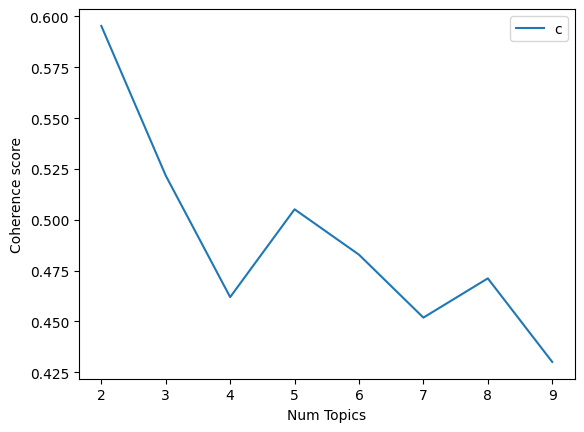

The optimal number of topics is: 2


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['tokens'], start=2, limit=10, step=1)

limit=10; start=2; step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

optimal_num_topics = x[np.argmax(coherence_values)]
best_model = model_list[np.argmax(coherence_values)]
print(f"The optimal number of topics is: {optimal_num_topics}")

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=100, update_every=1, chunksize=10, passes=10, alpha='auto', per_word_topics=True)

topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.023*"township" + 0.012*"wildwood" + 0.009*"school" + 0.008*"county" + 0.008*"city" + 0.007*"site" + 0.007*"beach" + 0.007*"residents" + 0.007*"new" + 0.006*"pittsgrove"')
(1, '0.026*"fire" + 0.021*"office" + 0.020*"municipal" + 0.020*"community" + 0.019*"clerk" + 0.019*"emergency" + 0.015*"services" + 0.014*"department" + 0.013*"planning" + 0.013*"court"')
(2, '0.046*"health" + 0.029*"people" + 0.015*"average" + 0.015*"age" + 0.013*"medical" + 0.013*"sex" + 0.011*"number" + 0.011*"behavior" + 0.010*"sexual" + 0.008*"population"')


In [ ]:
#5
#(0, '0.079*"health" + 0.042*"people" + 0.020*"average" + 0.019*"age" + 0.019*"behavior" + 0.018*"use" + 0.017*"medical" + 0.017*"sex" + 0.015*"number" + 0.012*"sexual"')
#(1, '0.068*"municipal" + 0.042*"court" + 0.034*"education" + 0.024*"page" + 0.017*"county" + 0.016*"school" + 0.013*"wildwood" + 0.013*"city" + 0.012*"beach" + 0.011*"local"')
#(2, '0.074*"fire" + 0.042*"services" + 0.033*"department" + 0.031*"community" + 0.028*"emergency" + 0.018*"facebook" + 0.013*"management" + 0.013*"human" + 0.012*"field" + 0.010*"safety"')
#(3, '0.054*"township" + 0.026*"public" + 0.021*"police" + 0.021*"information" + 0.019*"animal" + 0.013*"phone" + 0.013*"business" + 0.012*"new" + 0.012*"recreation" + 0.012*"site"')
#(4, '0.056*"office" + 0.049*"clerk" + 0.034*"planning" + 0.031*"board" + 0.030*"tax" + 0.029*"finance" + 0.023*"community" + 0.023*"emergency" + 0.019*"borough" + 0.014*"code"')

#3
#(0, '0.023*"township" + 0.012*"wildwood" + 0.009*"school" + 0.008*"county" + 0.008*"city" + 0.007*"site" + 0.007*"beach" + 0.007*"residents" + 0.007*"new" + 0.006*"pittsgrove"')
#(1, '0.026*"fire" + 0.021*"office" + 0.020*"municipal" + 0.020*"community" + 0.019*"clerk" + 0.019*"emergency" + 0.015*"services" + 0.014*"department" + 0.013*"planning" + 0.013*"court"')
#(2, '0.046*"health" + 0.029*"people" + 0.015*"average" + 0.015*"age" + 0.013*"medical" + 0.013*"sex" + 0.011*"number" + 0.011*"behavior" + 0.010*"sexual" + 0.008*"population"')

# NMF

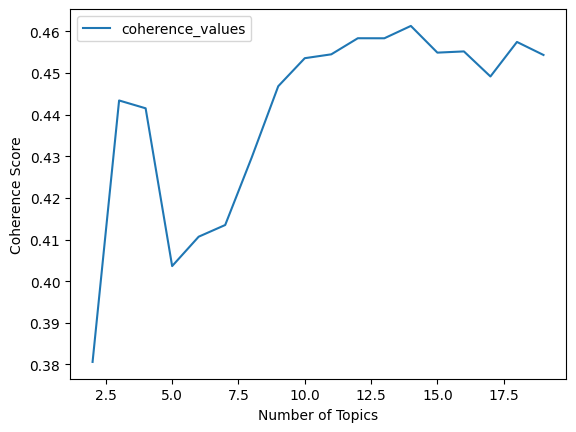

Topic 0:
householder husband couples present children female non families households age
Topic 1:
municipal board health planning tax public court office water vital
Topic 2:
older individuals years households age nfirs year number reporting data
Topic 3:
age poverty line population families none total sources territory decade
Topic 4:
crime higher average cost violent rate median low monthly lower
Topic 5:
fire department prevention incident company incidents number volunteer police reporting
Topic 6:
emergency everbridge alerts police delran management office department dept sewer
Topic 7:
trash civic event board tax borough fleche mercantile renewal game
Topic 8:
residents offenders sex ratio city state detailed races foreign ancestries
Topic 9:
people behavior health average sexual accidents fatal locations conditions medical
Topic 10:
war revolutionary civil world american site cemetery battlefield national battle
Topic 11:
personal information delran links qualifications notices 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tokens'])

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = NMF(n_components=num_topics, random_state=42)
        W = model.fit_transform(tfidf_matrix)
        H = model.components_
        model_list.append(model)


        topics = []
        for topic in H:
            top_words = [dictionary.id2token[i] for i in topic.argsort()[:-11:-1]]
            topics.append(top_words)


        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

start = 2
limit = 20
step = 1

model_list, coherence_values = compute_coherence_values(dictionary, corpus, df['tokens'], limit, start, step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(["coherence_values"], loc='best')
plt.show()

optimal_model = model_list[np.argmax(coherence_values)]
optimal_num_topics = start + np.argmax(coherence_values) * step

feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(optimal_model.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))